# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 10 : Exploratory analysis of normalized read counts


- 0. 1 - Setting up this R session on IFB core cluster  
- 0. 2 - Parameters to be set or modified by the user   
- 1 - Loading input data    
- 2 -    
- 3 -    


- 4 - Saving our results for later use : RData file

---

## 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

In [2]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Sun Jun  4 23:36:15 CEST 2023 ==="                        
[2] "          33651711      fast  jupyter cvandied  R       3:48      1 cpu-node-7"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                        
[4] "       JobID  AllocCPUS        NodeList "                                      
[5] "------------ ---------- --------------- "                                      
[6] "33651711              5      cpu-node-7 "                                      


__

Next we load into this R session the various tools that we will use.   
***DO NOT worry*** if you see a large red output!!   
You should see this large red output only once, when the relevant packages are installed in your home directory. Afterwards, they will be detected as present, and this large red output won't show if you run the cell another time.

In [3]:
## Code cell 2 ##

if (!require("ggfortify", quietly = TRUE)) {
    install.packages("ggfortify")}

if (!require("ggrepel", quietly = TRUE)) {
    install.packages("ggrepel")}

if (!require("affy", quietly = TRUE)) {
    install.packages("affy")}

if (!require("ComplexHeatmap", quietly = TRUE)) {
    install.packages("ComplexHeatmap")}

library("RColorBrewer")
library("ggplot2")
library("stringr")
library("matrixStats")
library("ggfortify")
library("ggrepel")
library("affy")
library("pheatmap")
library("DESeq2", quietly = TRUE)
library("ComplexHeatmap")


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgna

---

## 0.2 - Parameters to be set or modified by the user


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

In [4]:
## Code cell 4 ##


gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

# In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened
getwd()
setwd("/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet") # temporaire pour mettre le jupynb en place
myfolder <- getwd()
myfolder


[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/pipeline"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this exploratory analysis will be stored. As it is a logical step usually performed together with the normalisation by `DESeq2`, we can stay in the same output folder :

In [5]:
## Code cell 5 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
# we can skip this step as the folder is already created
# dir.create(paste(myfolder,"/Results/deseq2/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/deseq2/"

[1] "total 23M"                                                                          
[2] "-rw-rw----+ 1 scaburet scaburet  22M Jun  2 12:12 deseq2.RData"                     
[3] "-rw-rw----+ 1 scaburet scaburet 356K Jun  2 12:12 DESeq2_significant_genes-0_05.tsv"


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [6]:
## Code cell 6 ##

options(repr.plot.width=15, repr.plot.height=8)

## 1 - Loading input data and metadata

We now need to retrieve the normalized data that we generated in the previous session.   
As we stored it in a global Rdata objet at the end of Pipe_09, we can simply reload all our information by opening this Rdata object.  

In [7]:
## Code cell 7 ##

rdata <- paste0(deseq2folder,"deseq2.RData")
rdata
load(rdata,verbose = TRUE)

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/deseq2/deseq2.RData"

Loading objects:
  logcountsdds2
  rlog.dds2
  res2_ranked_p
  deseq2folder
  counts.rlog.dds2
  gohome
  rdata
  samples
  conditionColor
  session_parameters
  contrastALL
  .pbd_env
  dds2
  .Random.seed
  countdata2
  myfolder
  counts.vst.dds2


We can now list all the object we have currently in our session: 

In [8]:
## Code cell 8 ##

ls() 

[1] "conditionColor"     "contrastALL"        "countdata2"        
 [4] "counts.rlog.dds2"   "counts.vst.dds2"    "dds2"              
 [7] "deseq2folder"       "gohome"             "logcountsdds2"     
[10] "myfolder"           "rdata"              "res2_ranked_p"     
[13] "rlog.dds2"          "samples"            "session_parameters"

What we need now is the `rlog.dds2` object, and more precisely, the `assay` portion in it, that contains the normalized read counts:

In [9]:
head(rlog.dds2)

class: DESeqTransform 
dim: 6 11 
metadata(1): version
assays(1): ''
rownames(6): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000102175.2 ENSMUSG00000103922.2
rowData names(27): baseMean baseVar ... maxCooks rlogIntercept
colnames(11): SRR12730403 SRR12730404 ... SRR12730412 SRR12730413
colData names(11): SampleID SampleName ... Tissue sizeFactor

In [10]:
head(assay(rlog.dds2), n = 5)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
ENSMUSG00000025902.14,2.2753837,1.7844995,5.2884251,5.0785500,5.8854530,6.2842913,1.8848576,1.8888486,1.8702935,1.7061761,2.0175685
ENSMUSG00000104238.2,-0.4808090,-0.4777344,-0.4754620,-0.4763427,-0.2539682,0.3804070,-0.4743753,-0.4742319,-0.4748919,-0.4800467,-0.4781996
ENSMUSG00000102269.2,0.9905249,1.1021238,0.9850394,0.7932449,0.9593785,1.1077793,0.9965492,0.9023834,0.8981402,0.9360354,0.9558681
ENSMUSG00000098104.2,7.2186175,7.2854975,7.6275423,7.4973094,7.5511432,7.2601744,7.9467515,7.1022852,7.5134550,7.6407675,7.5860592
ENSMUSG00000102175.2,0.2090871,0.3782832,0.3123558,0.5374955,0.2114604,0.3816452,0.2143432,0.2144627,0.4068486,0.4187628,0.2961543


We will use this matrix of normalized read counts as input for our in-depth exploratory analysis so we store it in specific object:

In [11]:
norm_counts <- assay(rlog.dds2)
dim(norm_counts)
head(norm_counts, n= 5)
summary(norm_counts)

[1] 22927    11

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
ENSMUSG00000025902.14,2.2753837,1.7844995,5.2884251,5.0785500,5.8854530,6.2842913,1.8848576,1.8888486,1.8702935,1.7061761,2.0175685
ENSMUSG00000104238.2,-0.4808090,-0.4777344,-0.4754620,-0.4763427,-0.2539682,0.3804070,-0.4743753,-0.4742319,-0.4748919,-0.4800467,-0.4781996
ENSMUSG00000102269.2,0.9905249,1.1021238,0.9850394,0.7932449,0.9593785,1.1077793,0.9965492,0.9023834,0.8981402,0.9360354,0.9558681
ENSMUSG00000098104.2,7.2186175,7.2854975,7.6275423,7.4973094,7.5511432,7.2601744,7.9467515,7.1022852,7.5134550,7.6407675,7.5860592
ENSMUSG00000102175.2,0.2090871,0.3782832,0.3123558,0.5374955,0.2114604,0.3816452,0.2143432,0.2144627,0.4068486,0.4187628,0.2961543


  SRR12730403       SRR12730404       SRR12730405       SRR12730406     
 Min.   :-0.8689   Min.   :-0.8664   Min.   :-0.8645   Min.   :-0.8652  
 1st Qu.: 2.1128   1st Qu.: 2.1083   1st Qu.: 2.1418   1st Qu.: 2.1711  
 Median : 5.6650   Median : 5.7422   Median : 5.7107   Median : 5.7555  
 Mean   : 6.0997   Mean   : 6.1250   Mean   : 6.1361   Mean   : 6.1568  
 3rd Qu.:10.0772   3rd Qu.:10.1073   3rd Qu.:10.1159   3rd Qu.:10.1271  
 Max.   :18.1101   Max.   :18.0739   Max.   :18.8260   Max.   :18.7675  
  SRR12730407       SRR12730408       SRR12730409       SRR12730410     
 Min.   :-0.8665   Min.   :-0.8661   Min.   :-0.8603   Min.   :-0.8597  
 1st Qu.: 1.9846   1st Qu.: 2.0412   1st Qu.: 2.0793   1st Qu.: 2.0617  
 Median : 5.5252   Median : 5.6648   Median : 5.5835   Median : 5.4440  
 Mean   : 6.0664   Mean   : 6.0987   Mean   : 6.0644   Mean   : 6.0352  
 3rd Qu.:10.1413   3rd Qu.:10.1340   3rd Qu.:10.0765   3rd Qu.:10.0588  
 Max.   :17.8827   Max.   :17.6974   Max.   :17.655

In order to have all the visualisation in a single session, we can plot again the distribution of normalised reads:

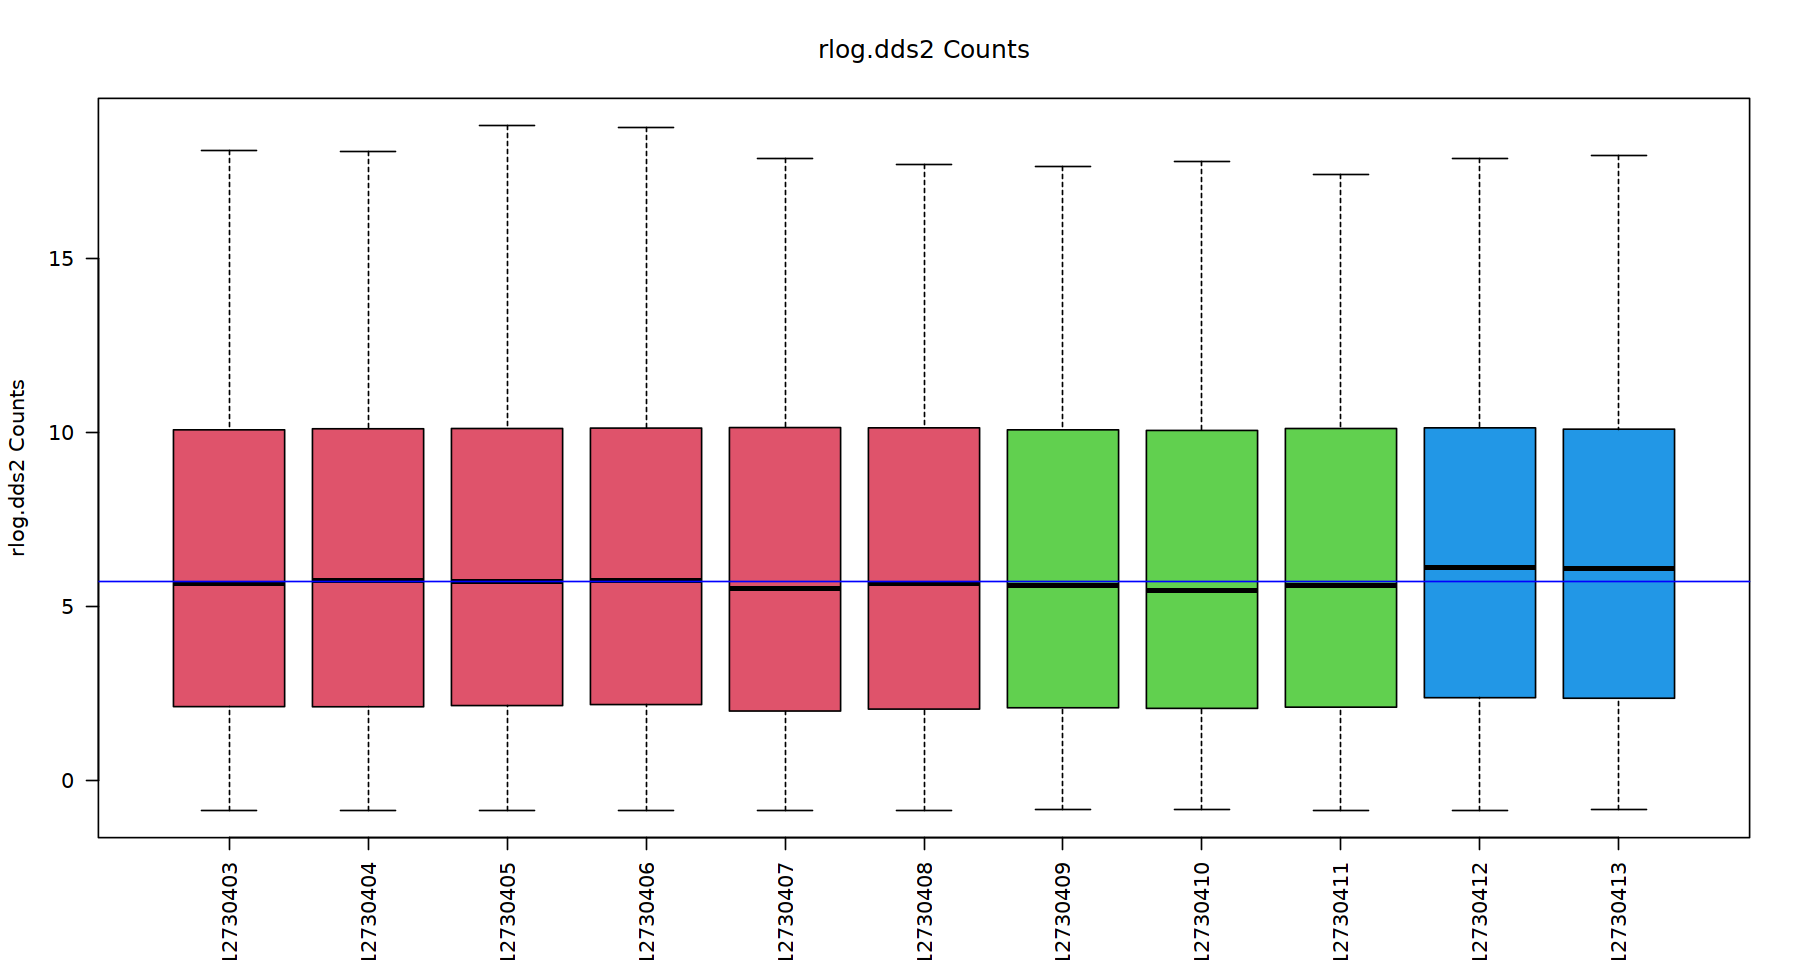

In [12]:
## Code cell 29 ##

# make a colour vector
conditionCol <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
boxplot(norm_counts,
        xlab="",
        ylab="rlog.dds2 Counts",
        las=2,
        col=conditionCol,
        main="rlog.dds2 Counts")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(norm_counts), col="blue")

## 2 - Principal Component analysis

In [13]:
## Code cell 31 ##

# run PCA
PCAdata <- prcomp(t(norm_counts))
summary(PCAdata)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     62.2353 52.5341 39.6708 27.66099 22.09445 16.28569
Proportion of Variance  0.3809  0.2714  0.1548  0.07525  0.04801  0.02608
Cumulative Proportion   0.3809  0.6524  0.8071  0.88239  0.93040  0.95649
                            PC7      PC8     PC9    PC10     PC11
Standard deviation     12.88620 11.48247 9.11928 7.83354 5.66e-14
Proportion of Variance  0.01633  0.01297 0.00818 0.00604 0.00e+00
Cumulative Proportion   0.97282  0.98579 0.99396 1.00000 1.00e+00

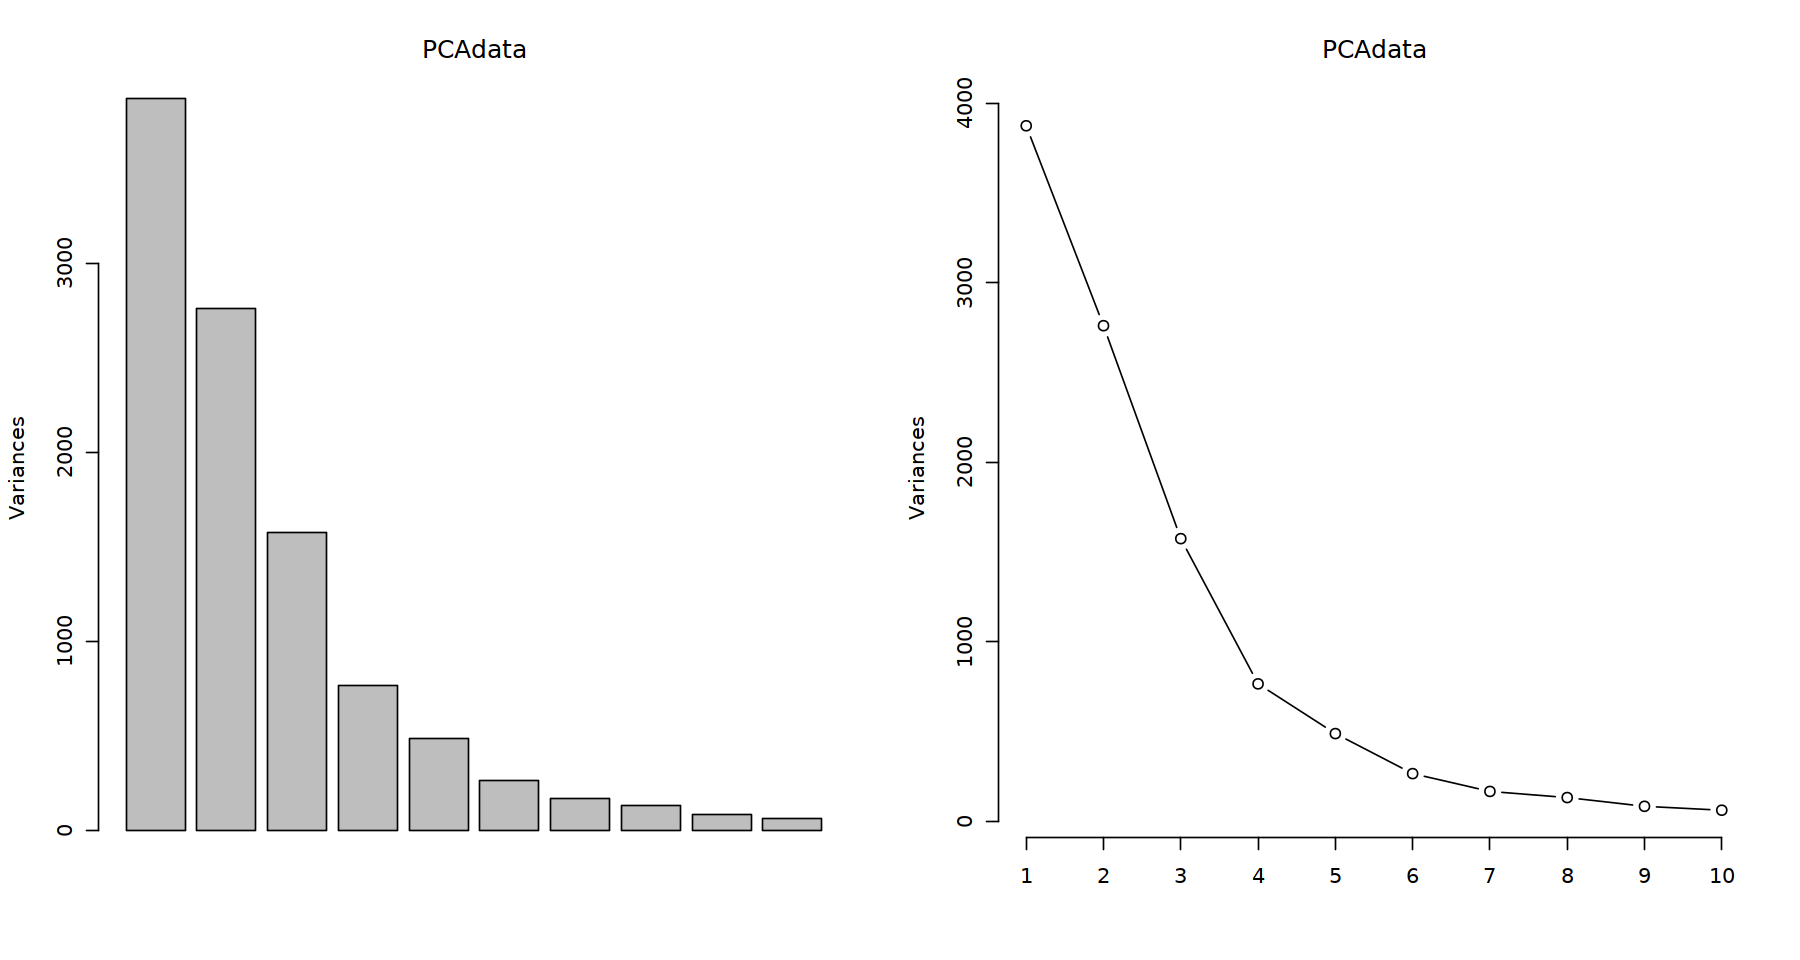

In [14]:
layout(matrix(1:2, ncol=2))
screeplot(PCAdata)
screeplot(PCAdata, type="lines")

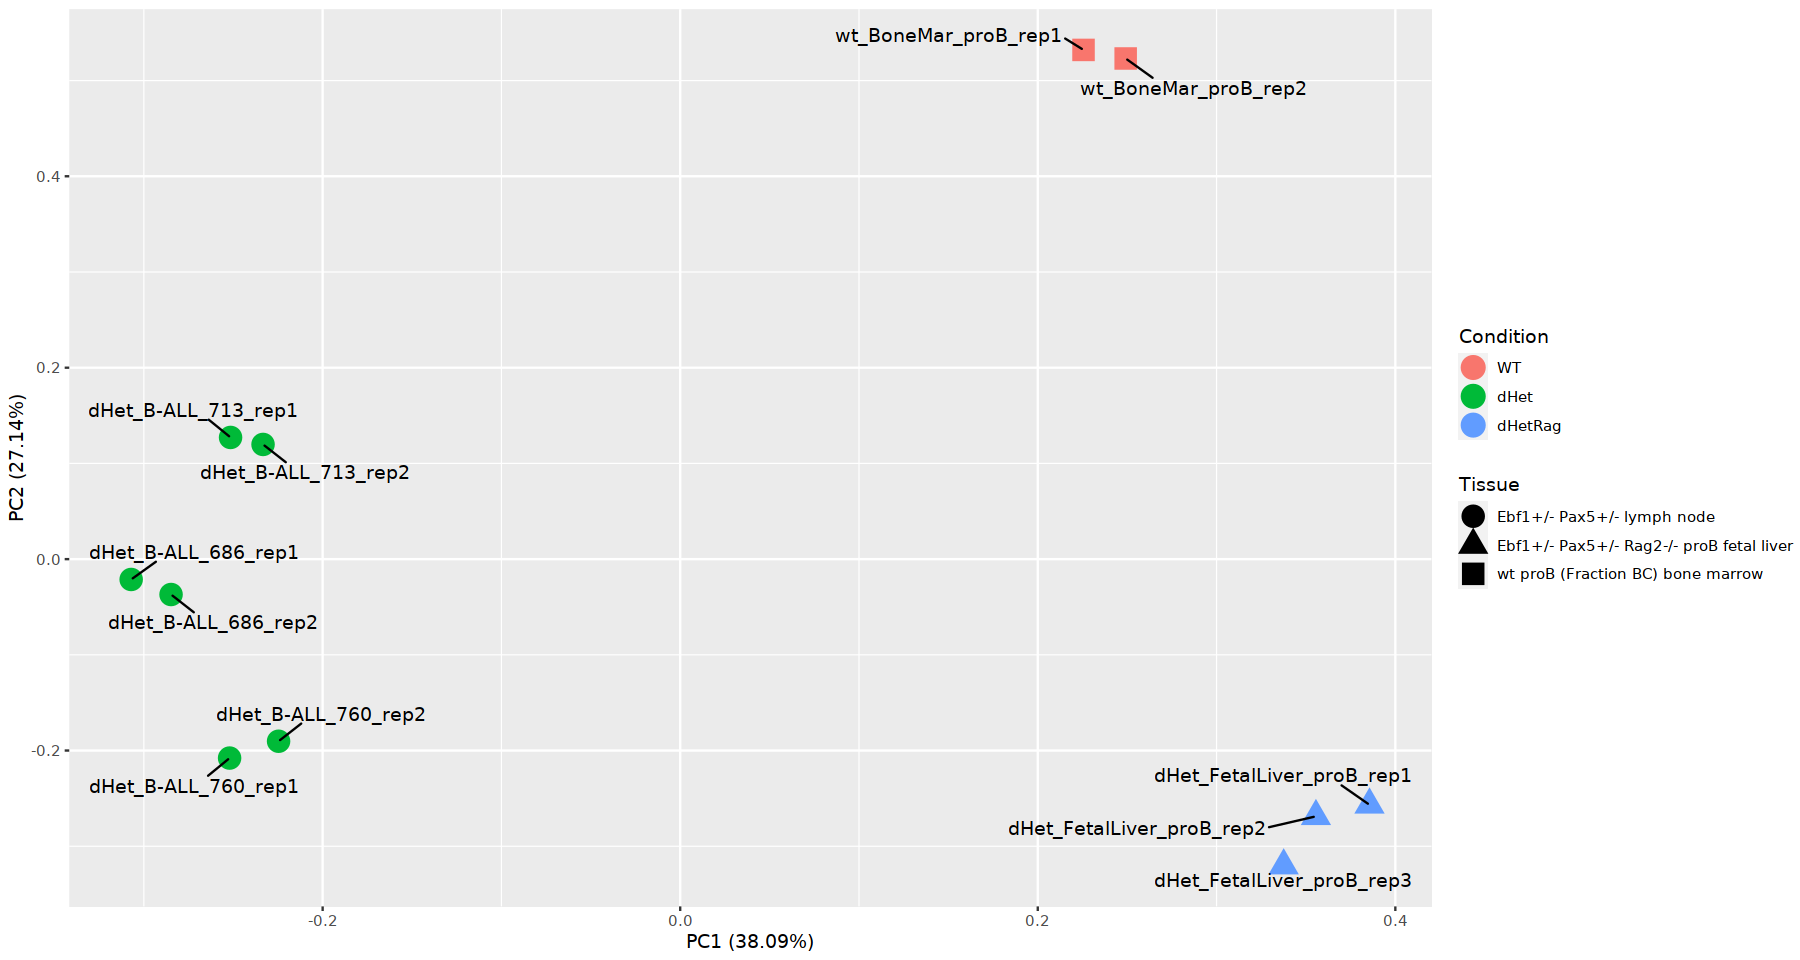

In [15]:
## Code cell 32 ##

autoplot(PCAdata,
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
        geom_text_repel(aes(x=PC1, y=PC2, label=SampleName), box.padding = 0.8)


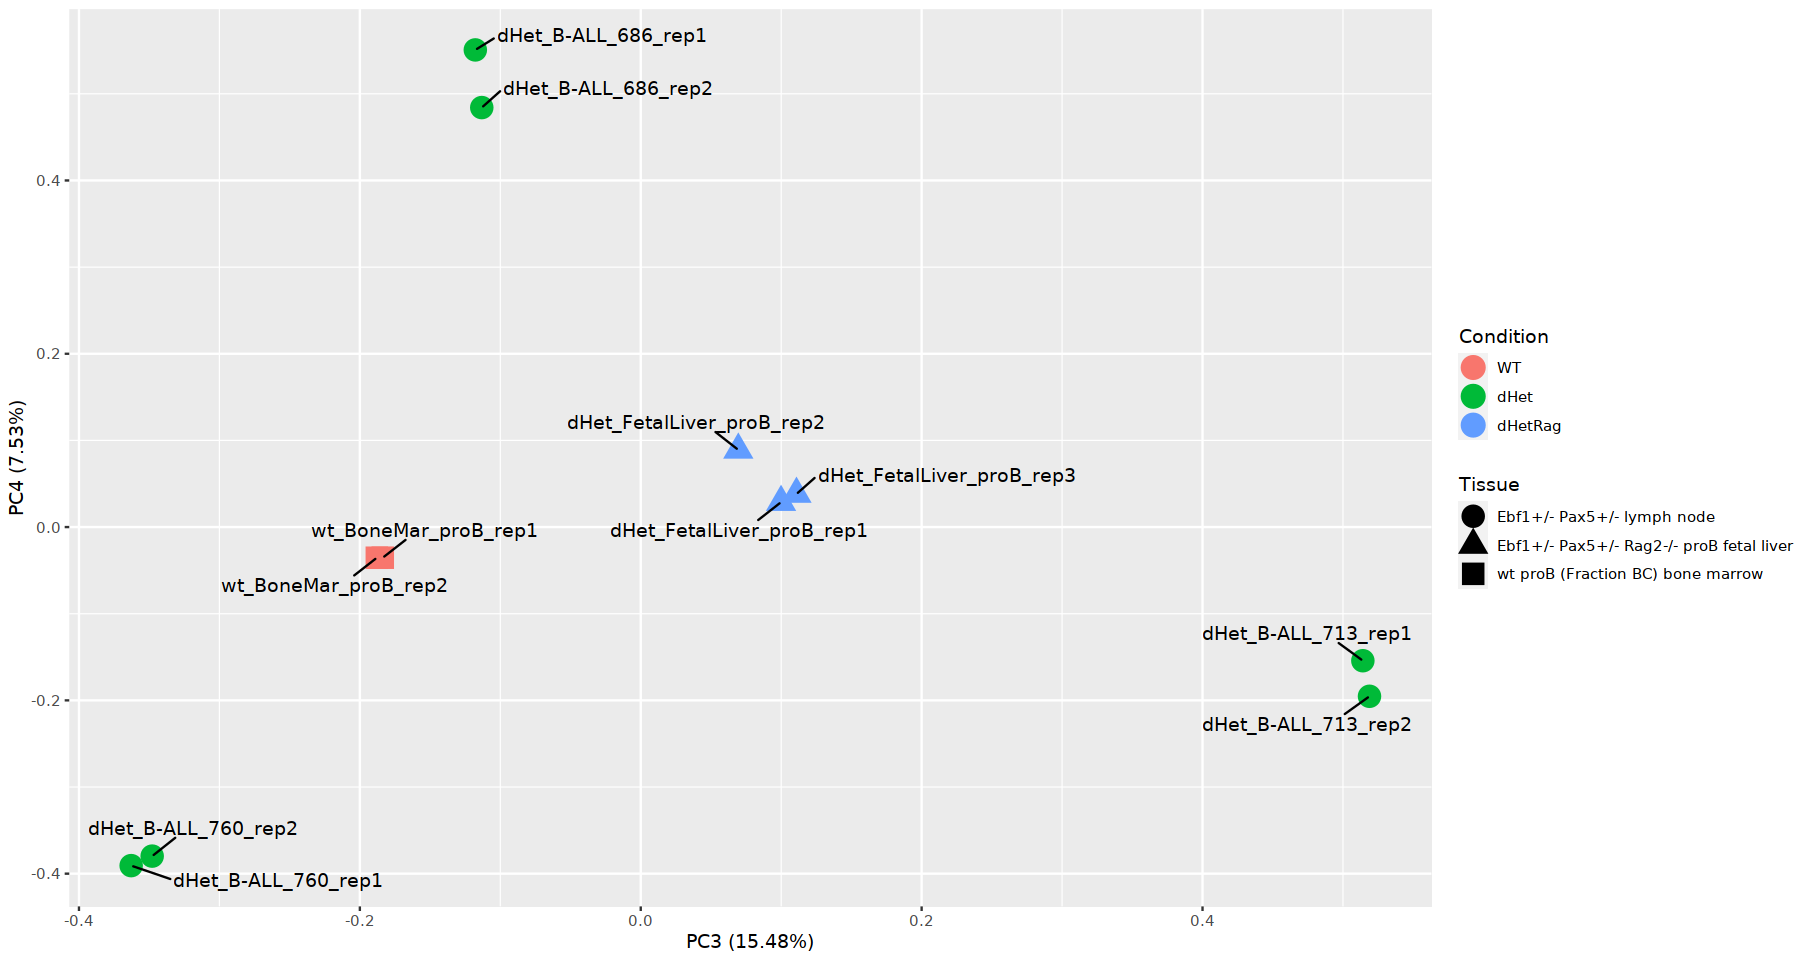

In [16]:
## Code cell 34 ##

autoplot(PCAdata,
         x = 3,    # PC3
         y = 4,    # PC4
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
    geom_text_repel(aes(x=PC3, y=PC4, label=SampleName), box.padding = 0.8)


In [17]:
    # Load package
    library("factoextra")

    # Create groups
    group <- c(rep("dHet_ALL", times=16), rep("dHet_proB", times=14), rep("wt_proB", times=3))
    # Plot
    fviz_pca_biplot(PCAdata, repel=TRUE, pointsize=6, pointshape=21, col.var="red", arrowsize=0.6, labelsize=5, col.ind=group, palette=c("green2", "gold", "skyblue2"), addEllipses=TRUE, ellipse.type="confidence")

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



ERROR: Error in fviz(X, element = "ind", axes = axes, geom = geom.ind, habillage = habillage, : The length of color variableshould be the same as the number of rows in the data.


Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”


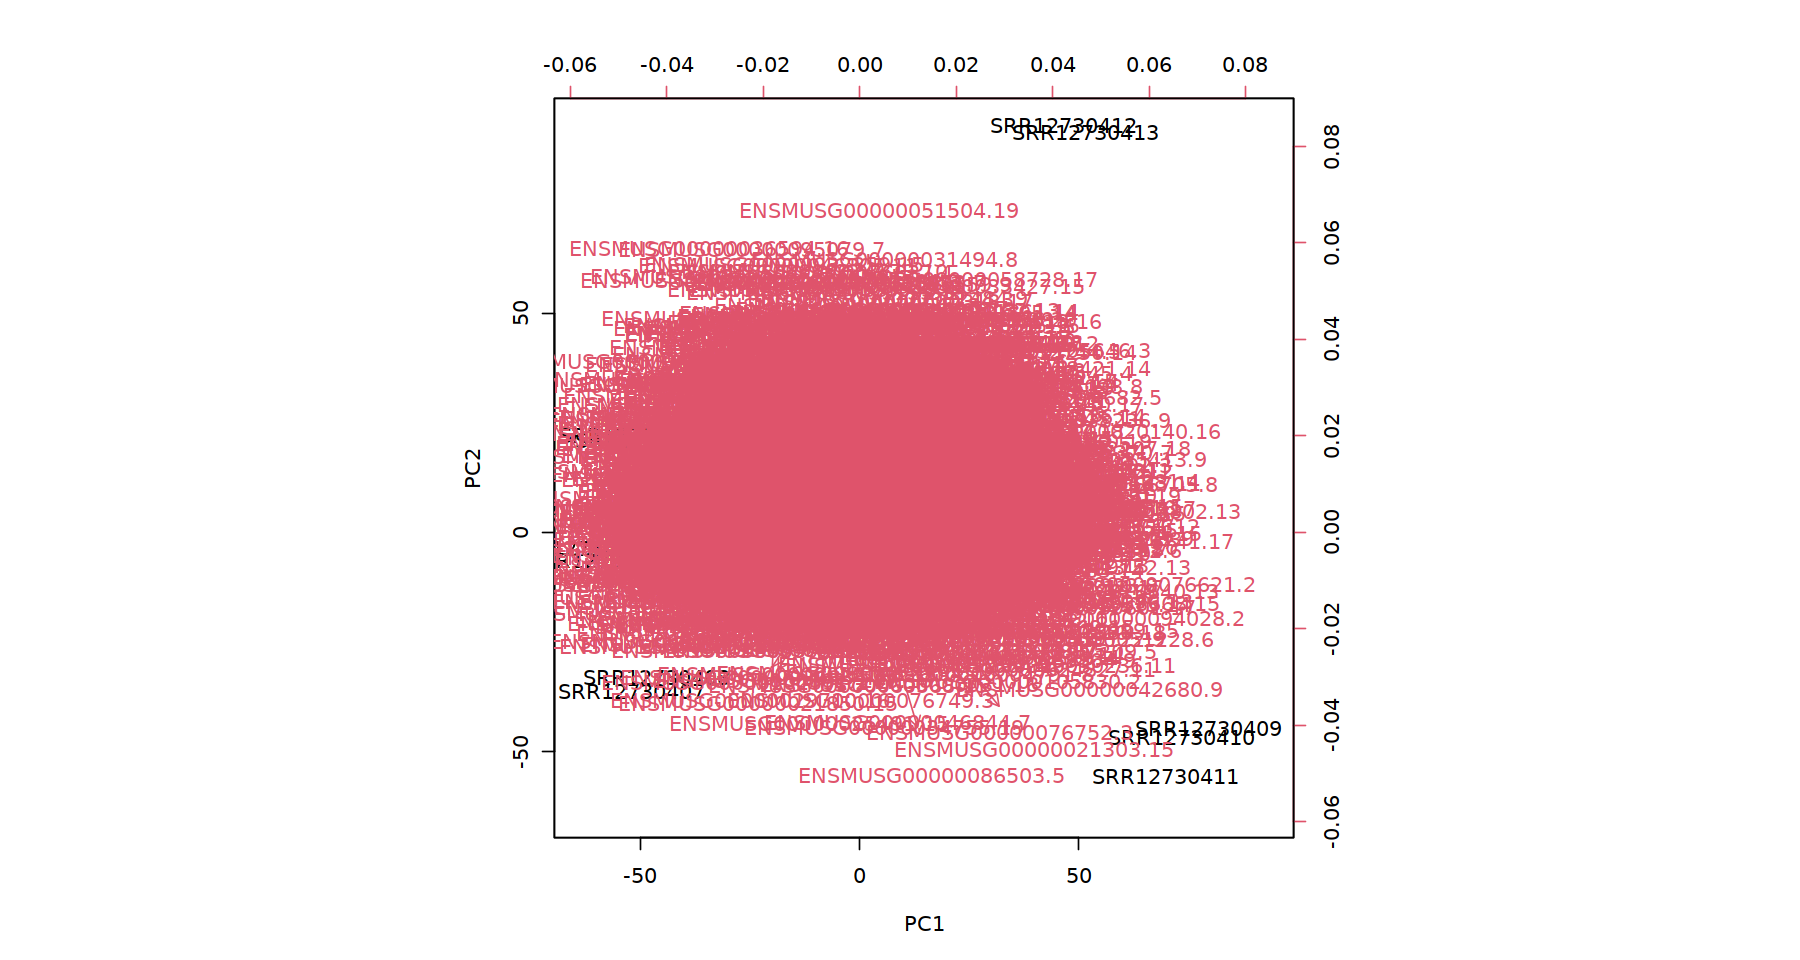

In [18]:
biplot(PCAdata, 
       scale = 0)

We can see that now that we look at the normalised data, PC1 separates clearly the leukemic cells from the non-leukemic cells, and that PC2 separates clearly the dHet cells from the WT ones. Again PC3 and PC4 seem to  separate the various mice, and to group the replicates.   
    
Although we can see a nice separation for our dataset, it is not recommended to use all the genes to perform a PCA. Indeed, the differences between the conditions is likely to be due to a more limited number of genss that do vary because of the conditions.
So the gens under consideration for a PCA are usually restricted to the more variant ones, i.e the 1000 most variable genes, of the top 5 or 10 %.   


In [19]:
head(norm_counts)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
ENSMUSG00000025902.14,2.2753837,1.7844995,5.2884251,5.0785500,5.8854530,6.2842913,1.8848576,1.8888486,1.8702935,1.7061761,2.0175685
ENSMUSG00000104238.2,-0.4808090,-0.4777344,-0.4754620,-0.4763427,-0.2539682,0.3804070,-0.4743753,-0.4742319,-0.4748919,-0.4800467,-0.4781996
ENSMUSG00000102269.2,0.9905249,1.1021238,0.9850394,0.7932449,0.9593785,1.1077793,0.9965492,0.9023834,0.8981402,0.9360354,0.9558681
ENSMUSG00000098104.2,7.2186175,7.2854975,7.6275423,7.4973094,7.5511432,7.2601744,7.9467515,7.1022852,7.5134550,7.6407675,7.5860592
ENSMUSG00000102175.2,0.2090871,0.3782832,0.3123558,0.5374955,0.2114604,0.3816452,0.2143432,0.2144627,0.4068486,0.4187628,0.2961543
ENSMUSG00000103922.2,5.4879658,5.6120498,5.6262906,5.3522473,5.7958246,5.1590202,5.1587966,4.9124878,5.1621085,5.4650184,5.4700902


In [54]:
table(table(row.names(norm_counts)))


    1 
22927 

In [21]:
length(unique(row.names(norm_counts)))

[1] 22927

In [22]:
var_genes <- rowVars(norm_counts)
length(which(is.na(var_genes))) # donc tous les gènes ont bien une variance non nulle

[1] 0

In [23]:
names(var_genes) <- row.names(norm_counts)
head(var_genes)
length(unique(var_genes))
table(table(var_genes)) # donc 12 gènes on t la même var
table(table(names(var_genes)))

ENSMUSG00000025902.14  ENSMUSG00000104238.2  ENSMUSG00000102269.2 
          3.626691719           0.067863677           0.008006892 
 ENSMUSG00000098104.2  ENSMUSG00000102175.2  ENSMUSG00000103922.2 
          0.058011354           0.011847199           0.067895118

[1] 22915


    1     2 
22903    12 


    1 
22927 

In [27]:
topVargenes <- head(sort(var_genes, decreasing = TRUE), 250)
head(topVargenes)

#topVarGenes <- head(sort(rowVars(norm_counts), decreasing = TRUE), 250) # ton code

ENSMUSG00000086503.5 ENSMUSG00000072553.11 ENSMUSG00000032554.16 
             18.34139              15.91809              14.82357 
ENSMUSG00000036594.16 ENSMUSG00000034755.19 ENSMUSG00000069049.12 
             13.43976              13.37198              13.25802

In [29]:
top250var  <- as.data.frame(norm_counts)[names(topVargenes),]
head(top250var)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000086503.5,2.552965,2.551950,3.248988,2.843007,10.453213,11.214720,11.610911,2.742484,11.983860,3.444767,2.730536
ENSMUSG00000072553.11,10.249616,10.327250,13.811508,13.694047,14.859809,14.307600,4.914597,4.840747,4.960577,7.553078,7.647970
ENSMUSG00000032554.16,13.734535,13.590517,9.501075,9.431954,13.612086,13.317965,4.844869,4.439586,4.277233,11.693340,11.915752
ENSMUSG00000036594.16,10.431688,10.420761,12.435894,12.403781,8.492730,8.539257,3.963705,3.971237,3.936229,13.138894,12.635126
ENSMUSG00000034755.19,3.612183,3.677282,10.857701,10.971400,12.219333,12.760905,11.197217,11.770727,10.151535,4.860586,5.286321
ENSMUSG00000069049.12,10.530544,10.375944,10.892690,10.870529,3.400189,3.428322,3.596315,10.688330,3.569074,11.019235,10.564475


In [30]:

dim(top250var)
head(top250var, n=25)
length(unique(row.names(top250var)))

[1] 250  11

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000086503.5,2.552965,2.551950,3.248988,2.843007,10.453213,11.214720,11.610911,2.742484,11.983860,3.444767,2.730536
ENSMUSG00000072553.11,10.249616,10.327250,13.811508,13.694047,14.859809,14.307600,4.914597,4.840747,4.960577,7.553078,7.647970
ENSMUSG00000032554.16,13.734535,13.590517,9.501075,9.431954,13.612086,13.317965,4.844869,4.439586,4.277233,11.693340,11.915752
ENSMUSG00000036594.16,10.431688,10.420761,12.435894,12.403781,8.492730,8.539257,3.963705,3.971237,3.936229,13.138894,12.635126
ENSMUSG00000034755.19,3.612183,3.677282,10.857701,10.971400,12.219333,12.760905,11.197217,11.770727,10.151535,4.860586,5.286321
ENSMUSG00000069049.12,10.530544,10.375944,10.892690,10.870529,3.400189,3.428322,3.596315,10.688330,3.569074,11.019235,10.564475
ENSMUSG00000069045.12,10.996872,10.753347,10.769637,10.814613,3.496261,3.675321,3.692737,10.986754,4.501585,11.137718,11.010949
ENSMUSG00000050650.8,10.667632,10.775919,2.326860,2.281916,7.695276,8.059032,3.028980,2.386758,3.795786,2.069475,2.180667
ENSMUSG00000051504.19,5.240420,4.924260,6.551127,6.697537,3.272241,3.012458,2.590890,2.598021,2.564837,12.347554,11.644256


[1] 250

In [31]:
## Code cell 31 ##

# run PCA
PCAdata2 <- prcomp(t(top250var))


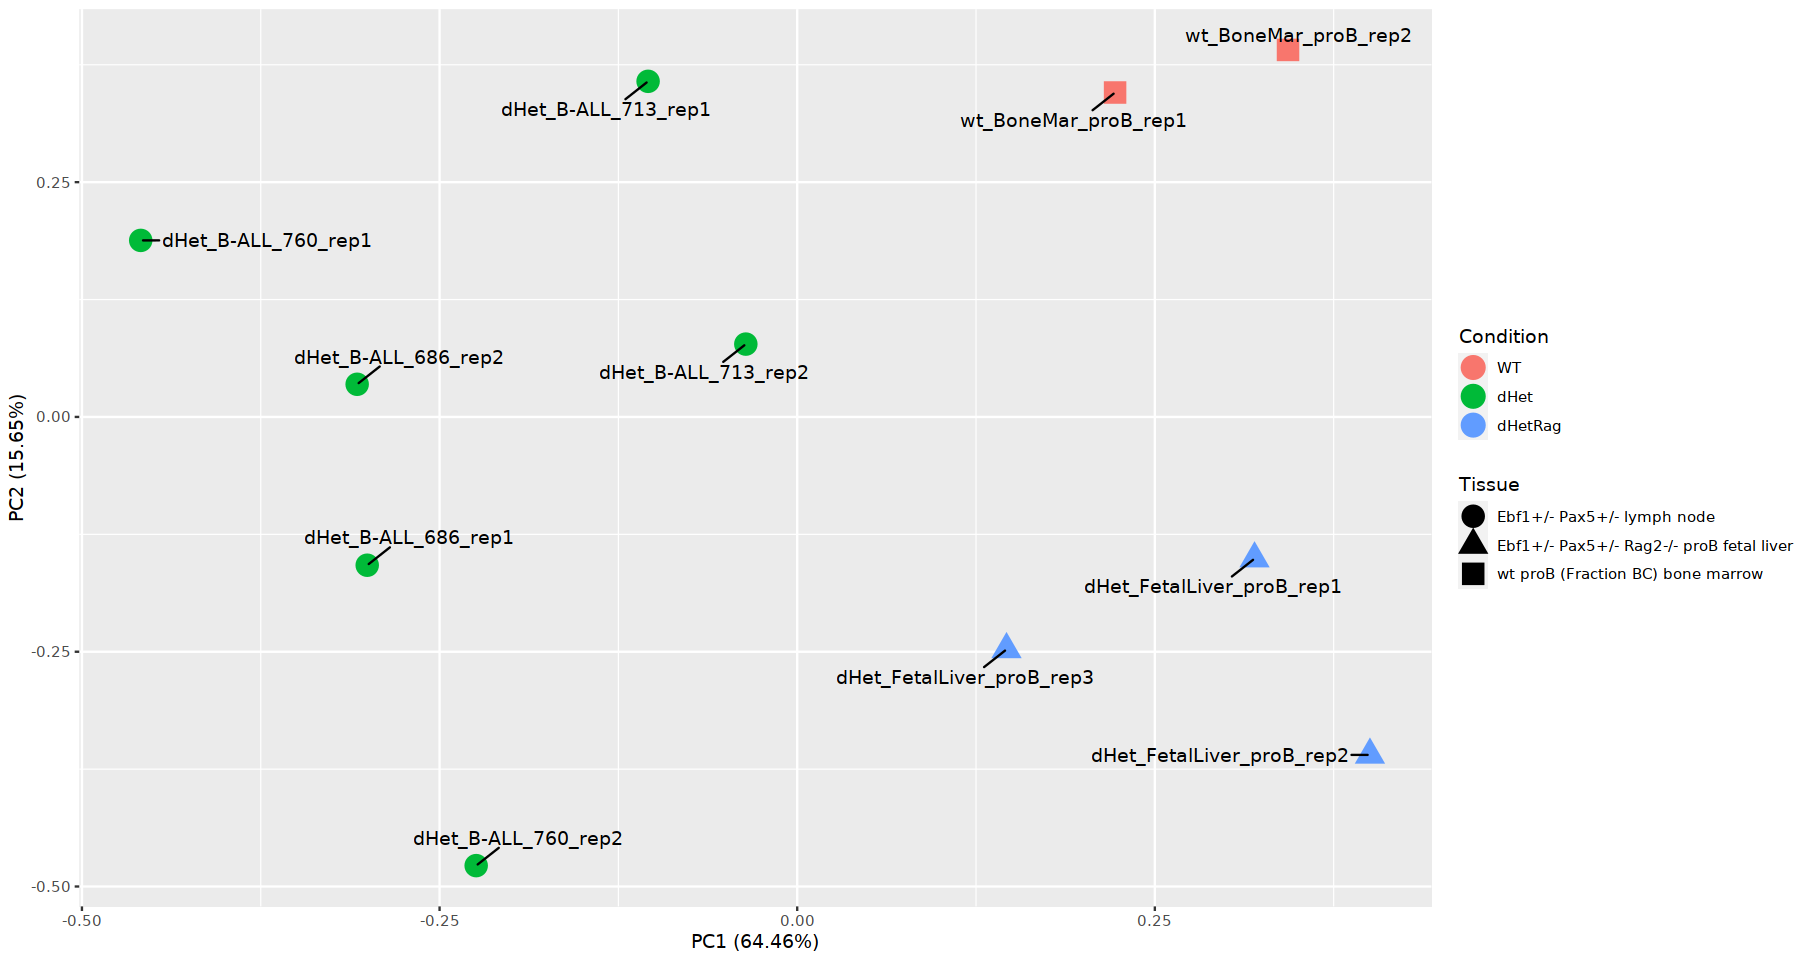

In [32]:
## Code cell 32 ##

autoplot(PCAdata2,
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
        geom_text_repel(aes(x=PC1, y=PC2, label=SampleName), box.padding = 0.8)


In [33]:
head(PCAdata2$rotation)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
ENSMUSG00000090031.4,0.04489729,0.008616567,-0.04711142,0.007583616,0.06431892,0.1257584,0.04690955,-0.20474172,-0.56229690,0.02190610,-0.64756275
ENSMUSG00000002459.18,-0.53408290,-0.134323842,0.04250683,0.423689046,0.32788350,0.4783468,0.29814884,-0.06611307,0.09323078,-0.02412966,-0.10261757
ENSMUSG00000103280.2,-0.01762521,-0.052575915,-0.04452684,-0.041919660,0.06159877,0.2600724,-0.25362120,0.59591665,-0.45955497,0.48768643,0.14650448
ENSMUSG00000062588.5,-0.04300472,0.018311636,0.06566901,0.206318859,0.28112672,-0.1447284,-0.11346122,0.13443229,0.11469533,0.05797669,-0.04287439
ENSMUSG00000062588.5,-0.04300472,0.018311636,0.06566901,0.206318859,0.28112672,-0.1447284,-0.11346122,0.13443229,0.11469533,0.05797669,-0.02080331
ENSMUSG00000062588.5,-0.04300472,0.018311636,0.06566901,0.206318859,0.28112672,-0.1447284,-0.11346122,0.13443229,0.11469533,0.05797669,0.26819327


In [ ]:
Diagramme des éboulis à faire si factominer

Bi-plot

In [34]:
biplot(PCAdata,
col = c('darkblue', 'red'),
scale = 0, xlabs = rep("*", 150))

ERROR: Error in dimnames(x) <- list(xlabs, dimnames(x)[[2L]]): length of 'dimnames' [1] not equal to array extent


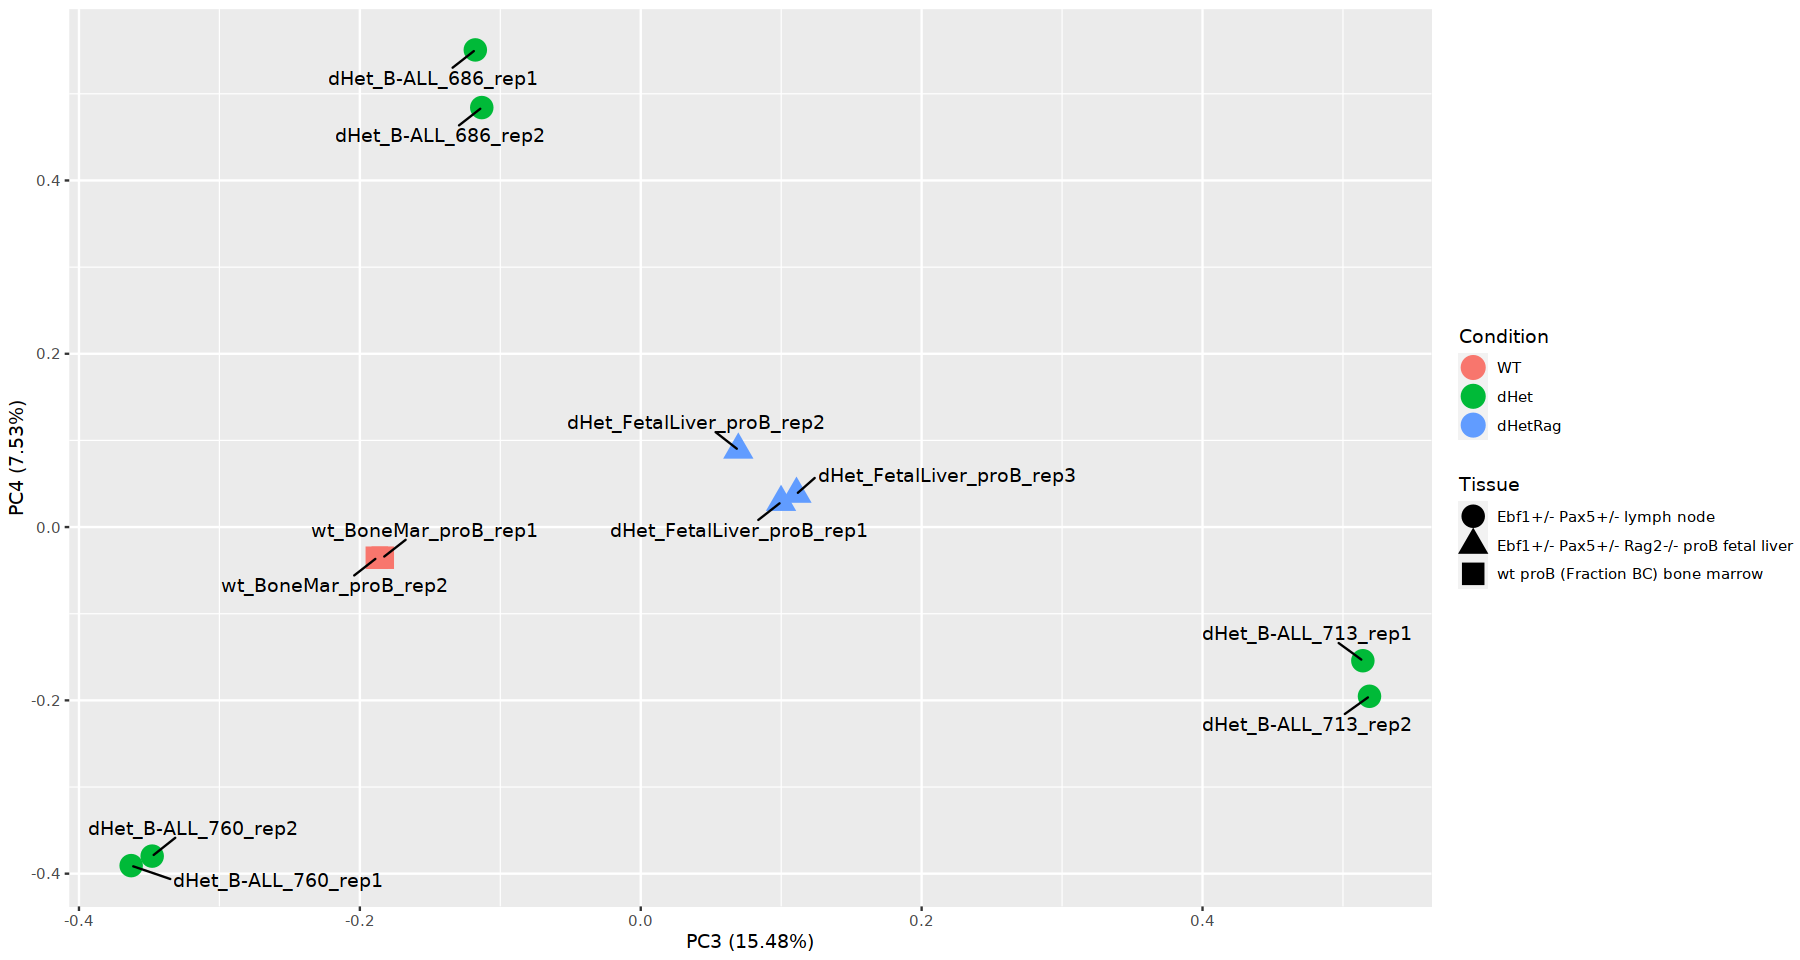

In [35]:
## Code cell 34 ##

autoplot(PCAdata,
         x = 3,    # PC3
         y = 4,    # PC4
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
    geom_text_repel(aes(x=PC3, y=PC4, label=SampleName), box.padding = 0.8)


---  


## 3 - Heatmaps and Clustering

### 3.1 - simple heatmaps 

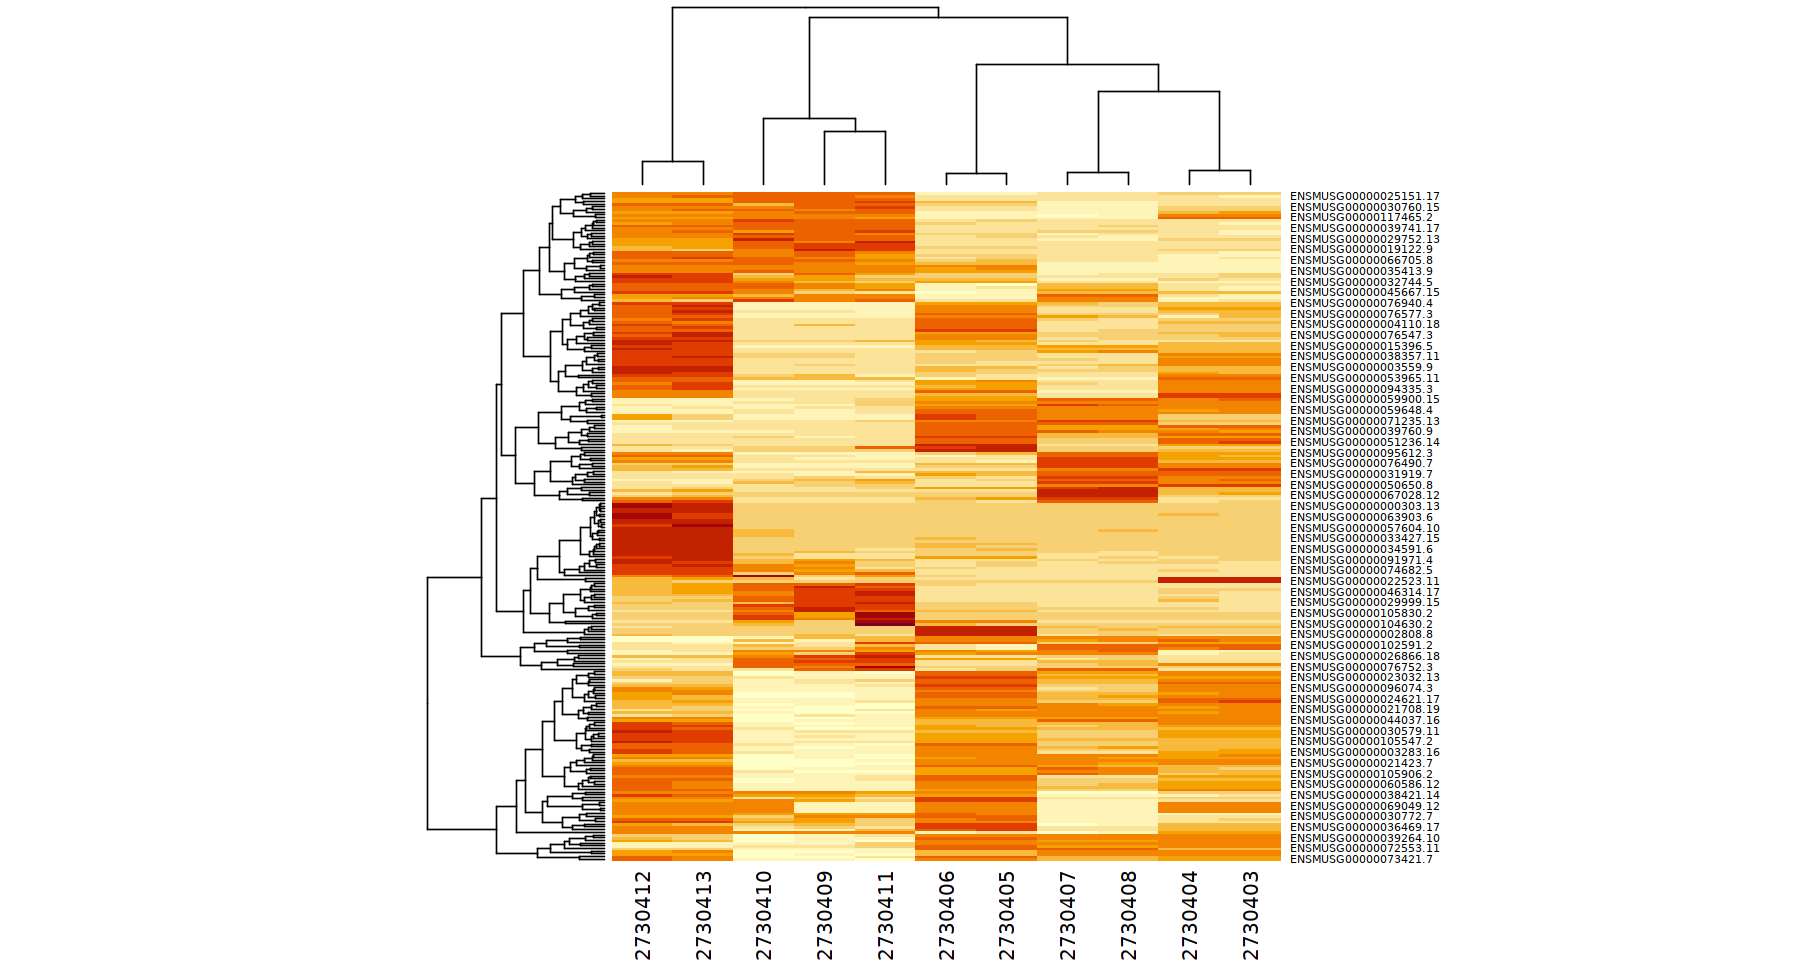

In [32]:

heatmap(as.matrix(top250var))

### 3.2 - Enhanced heatmaps with `ComplexHeatmap`
---

There are two main packages to draw enhanced heatmaps:
- [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html): a CRAN packages.
- [ComplexHeatmap](https://jokergoo.github.io/ComplexHeatmap-reference/book/) on GitHub but also available in Bioconductor, the second generation of pheatmap.

ComplexHeatmap is the most flexible tool to draw heatmaps with a lot of options, notably to add annotations.

Below is presented a quick example on ComplexHeatmap usage.

- Let's first take an output from limma DGE analysis, for example with the full model and the 34 differentially expressed genes. We will save it in a matrix format beacause ComplexHeatmap works with matrices.

In [10]:
# Code cell n°10

probes_sig <- subset(limma.full.outs$limma.fullmodel.out, adj.P.Val < 0.01 )[, "ProbeID"]
length(probes_sig)
mat_full <- norm.quant[row.names(norm.quant) %in% probes_sig,]
str(mat_full)
colnames(mat_full) <- samples_info$Status
row.names(mat_full) <- probes$TargetID[probes$ProbeID %in% probes_sig]

[1] 34

 num [1:34, 1:264] 7.84 7.41 7.54 10.67 9.16 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:34] "1820347" "6280440" "2510546" "6650079" ...
  ..$ : chr [1:264] "5753669129_B" "5753669129_C" "5753669129_E" "5753669129_K" ...


- To use ComplexHeatmap, the dataset must be a **matrix** with samples in columns and genes in rows. We thus transpose our matrix `mat_full`.

- In addition, we use the function `scale()` to **center our data with a Z score**:

In [42]:
# Code cell n°12

t_top250var <- t(apply(top250var, 1, scale))

- Then you select a **distance** for the similarity between samples. It can be a pre-defined character which is in ("euclidean", "maximum", "manhattan", "canberra", "binary", 
"minkowski", "pearson", "spearman", "kendall"). Default is "euclidean". It can also be a function. In R the function to compute distances is `dist()`. The correlation distance is defined as 1 - cor(x, y, method). [See there](https://jokergoo.github.io/ComplexHeatmap-reference/book/a-single-heatmap.html#distance-methods) for further details.

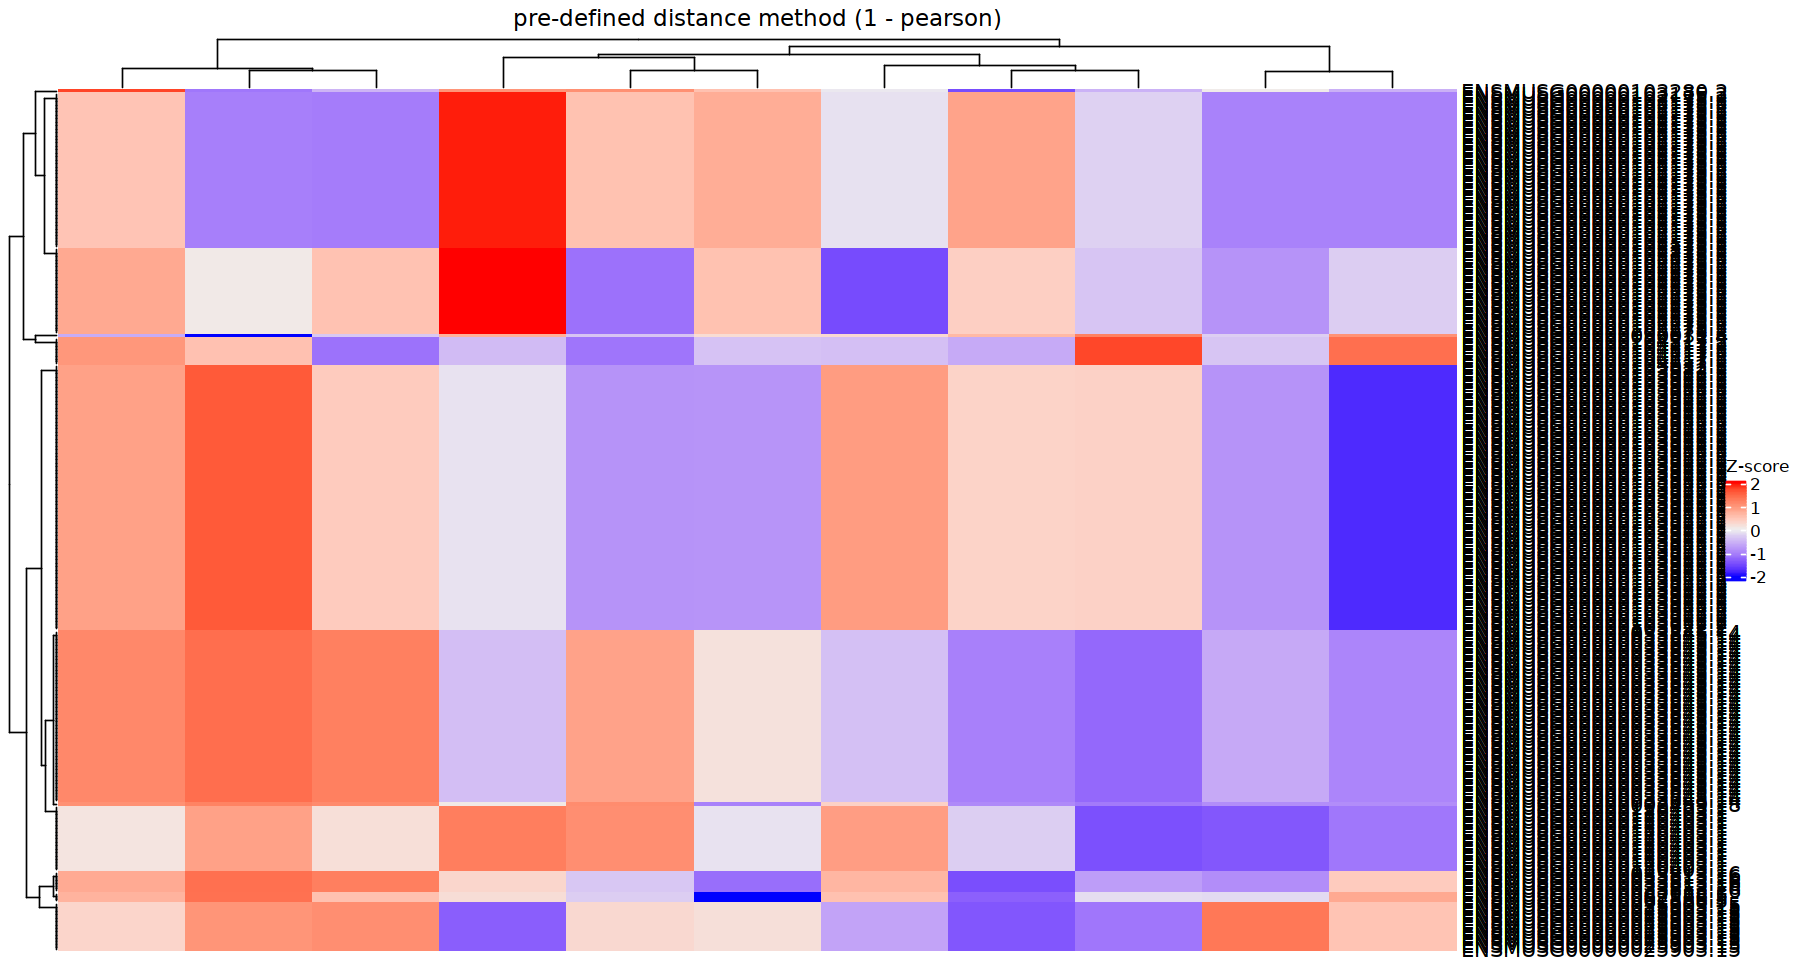

In [43]:
# Code cell n°13

ComplexHeatmap::Heatmap(t_top250var,
                        name = "Z-score",
                        clustering_distance_rows = "pearson",
                        column_title = "pre-defined distance method (1 - pearson)")

- You can also select the **clustering method** by `clustering_method_rows` and `clustering_method_columns`. Possible methods are those supported in `hclust()` function: "ward.D", "ward.D2", "single", "complete", "average" (= UPGMA), "mcquitty" (= WPGMA), "median" (= WPGMC) or "centroid" (= UPGMC).

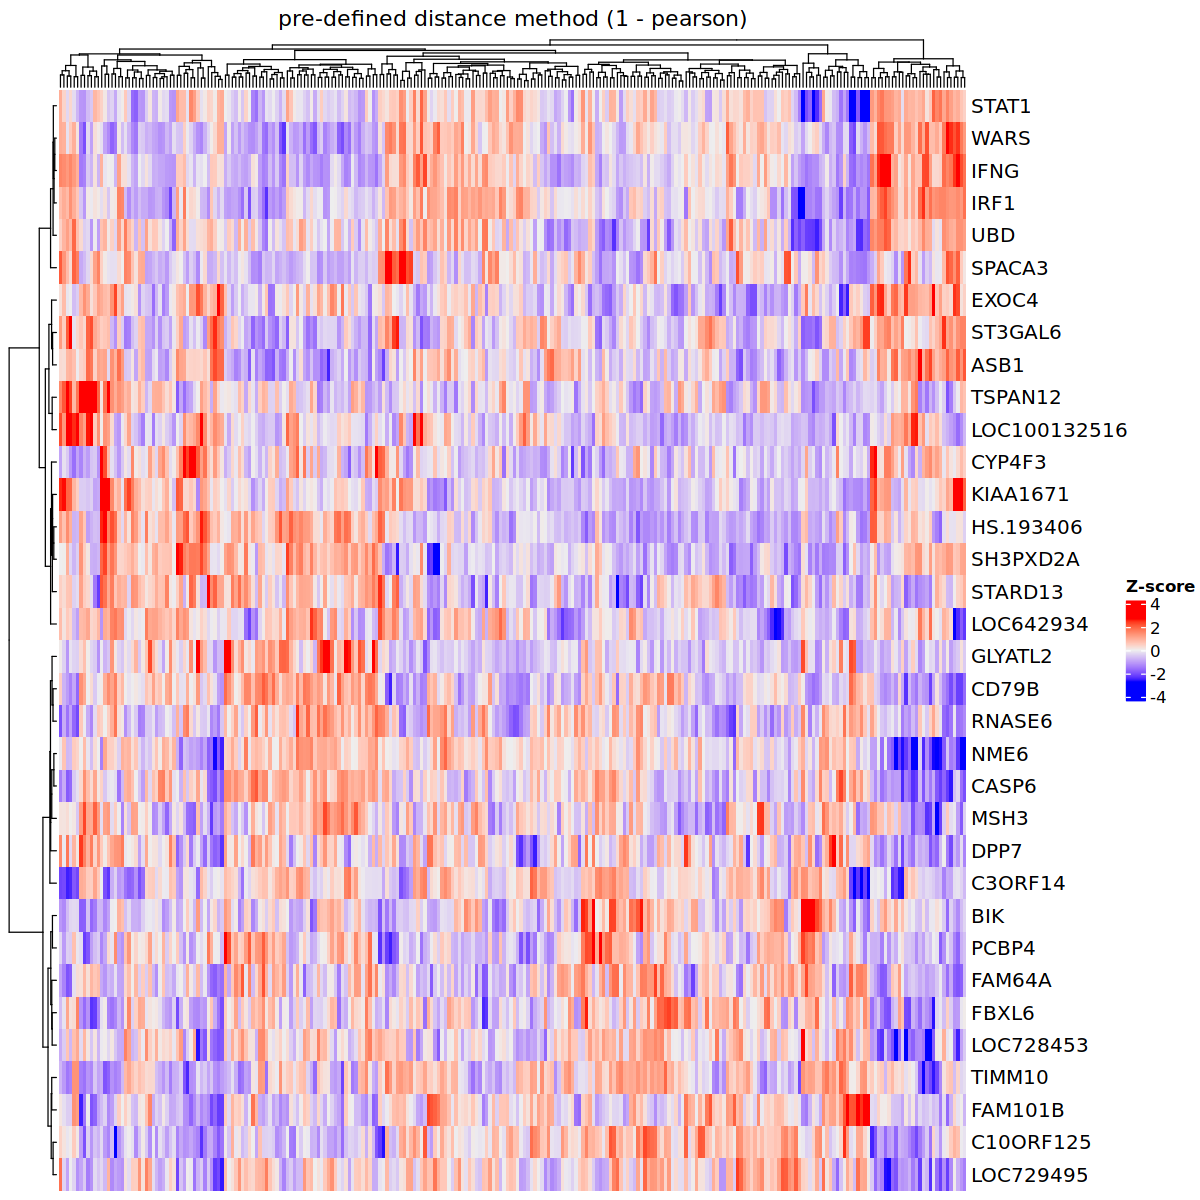

In [14]:
# Code cell n°14

ComplexHeatmap::Heatmap(tmat_full,
                        name = "Z-score",
                        clustering_distance_rows = "pearson",
                        column_title = "pre-defined distance method (1 - pearson)",
                        clustering_method_rows = "ward.D")

- One nice usage of ComplexHeatmap is the possibility to add custom **annotations**: `ha` for "heatmap annotation" is the object name used in ComplexHeatmap tutorial.

    - You can add annotations on samples, either quantitative with the fundtion `anno_points()` or `anno_barplot()` or qualitative with a dataframe. The `col` argument is used to specify the colors of the different categorical values. For the quantitative values, you can add points or boxplots for example.

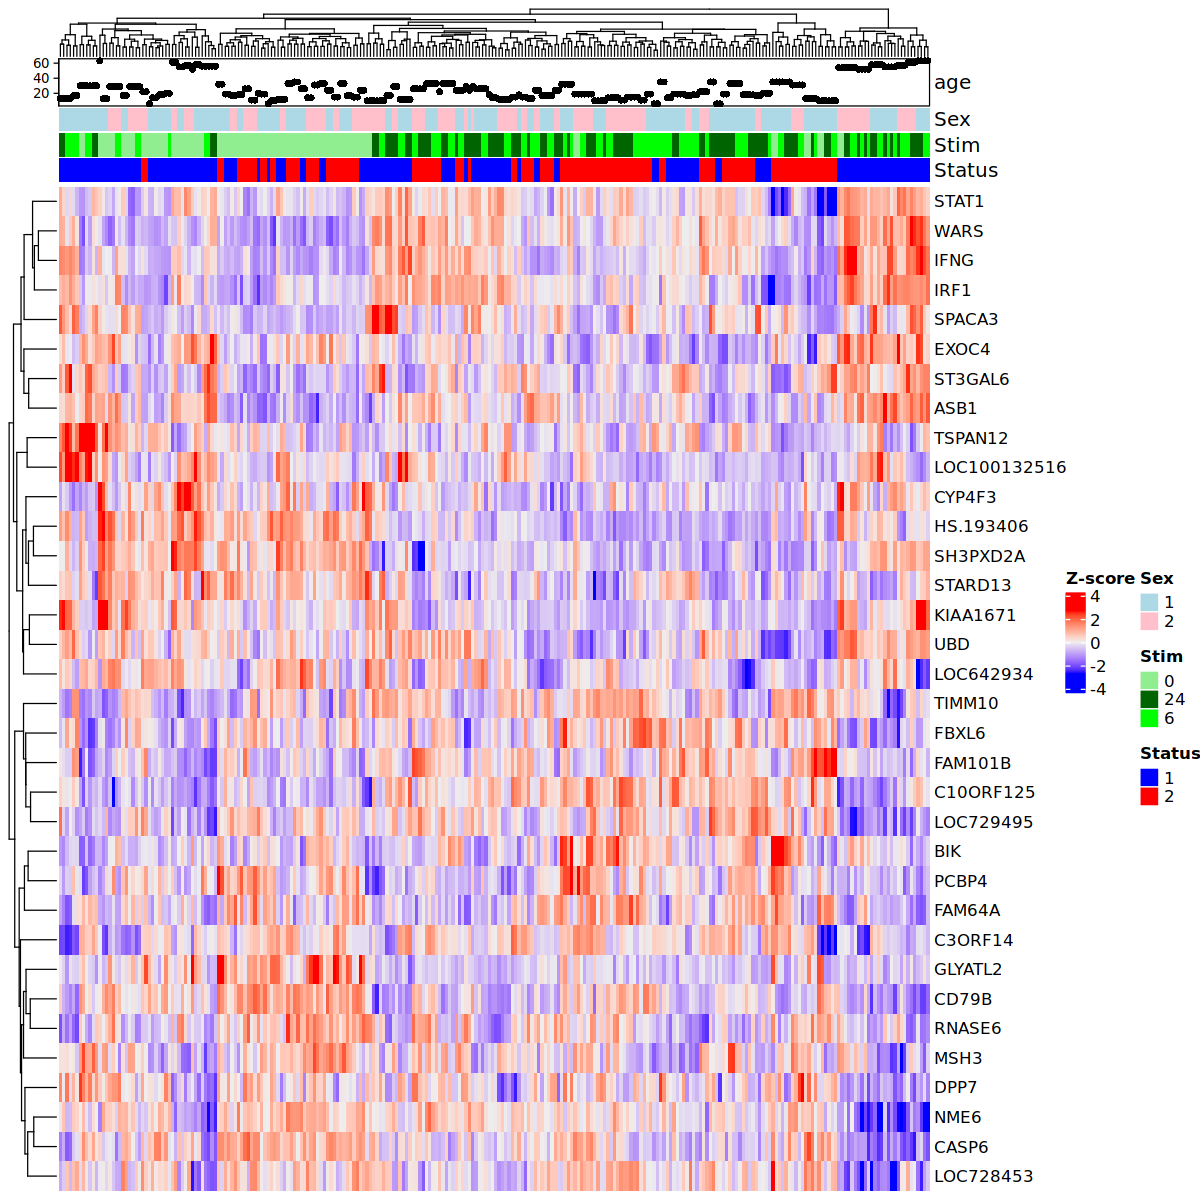

In [15]:
# Code cell n°15

ha <- HeatmapAnnotation(age = anno_points(samples_info$Age),
                        df = data.frame(Sex = samples_info$Sex,
                                        Stim = samples_info$Stim,
                                        Status = samples_info$Status),
                        col = list(Status = c("1" = "blue", "2" = "red"),
                                   Stim = c("0" = "lightgreen", "6"= "green", "24" = "darkgreen"),
                                   Sex = c("1" = "lightblue", "2" = "pink"))
                        )
ComplexHeatmap::Heatmap(tmat_full,
                        name = "Z-score",
                        top_annotation = ha,
                        row_names_gp = gpar(fontsize = 10)
                       )

---  

## 4 - Correlograms
---
*(estimated duration: 15 minutes)*

Gene co-expression correlations provide a robust methodology for predicting gene function, as genes sharing a biological process or a common implication in pathways are often co-regulated.  
We want to see if the DE genes identified in the previous analysis have a correlated expression in a pair-wise manner, that is if two genes share a similar pattern of expression across samples.

A Pearson or Spearman correlation is performed between continuous variables with the `cor()`  function, resulting in a correlation coefficient between each pair of genes. This correlation is displayed in a scatter plot with the function `plot()`.

<div class="alert alert-block alert-info"><b><u>What are correlograms?</u></b><br>
<br>When we want to study pairwise correlation between several variables (here genes are the variables), the <code>cor()</code> function can also be applied on a matrix of data. <b><br>
<i>A correlogram is the pairwise graphical representation of the matrix of correlation coefficients</i></b>. Such a correlogram helps highlighting the most correlated variables. Some R packages will also allow to display the pvalues or to reorder variables according to their degree of correlation.

You have arleady used heatmaps in session 1 to look at similar patterns of expression among a set of genes, such as the DE genes. Among distances that could be used to cluster genes in a heatmap, we could have used the Pearson distance = (1-r). In a correlogram, we rather display the <b><i>correlation coefficient ranging from -1 to 1</i></b>.
</div>

<span style="color:red">To have nice displays, it is often better to work on a small subset of genes. In this tutorial/practical, we decide to arbitrary use the DE genes at an adjusted pvalue of 0.001 to reduce the number of genes.</span>

<span style="color:blue"> => Find the command in cell 13 to assign the DE genes in a <code>probes_sig</code> object.

In [13]:
# Code cell n°13

probes_sig <- subset(DE, adj.P.Val < 0.001 )$ProbeID

Then we retrieve the normalised expression values for these probes:

In [14]:
# Code cell n°14

norm_sig <- norm.quant[probes_sig,]
str(norm_sig)

 num [1:27, 1:264] 7.34 11.93 6.66 7.41 7.54 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:27] "3120474" "3310376" "630725" "6280440" ...
  ..$ : chr [1:264] "5753669129_B" "5753669129_C" "5753669129_E" "5753669129_K" ...


and we add the annotations for samples and genes:

In [15]:
# Code cell n°15

colnames(norm_sig) <- samples_info$Full
row.names(norm_sig) <- DE$TargetID[1:nrow(norm_sig)]

norm_sig

,1_1_2_0,1_1_2_0,1_1_2_6,1_1_2_6,1_1_2_24,1_1_2_24,1_2_1_0,1_2_1_0,1_2_1_6,1_2_1_6,⋯,16_44_2_6,16_44_2_6,16_44_2_24,16_44_2_24,16_45_1_0,16_45_1_0,16_45_1_6,16_45_1_6,16_45_1_24,16_45_1_24
KIAA1671,7.343120,7.447613,7.216001,7.303913,7.326394,7.625109,8.352923,8.146731,8.108562,7.886871,⋯,7.192470,7.672861,7.514039,7.216330,8.853999,9.163023,8.308849,8.086358,8.817482,8.578759
TIMM10,11.930091,11.528976,11.809734,12.001712,11.926766,11.787124,11.216955,11.052444,11.238711,11.019660,⋯,11.745586,12.143564,11.890620,11.705762,11.737390,11.831913,11.935951,11.935951,11.909019,11.818191
IFNG,6.657629,6.386879,7.152258,7.431597,7.039594,7.329202,6.878076,7.014067,8.163466,7.776781,⋯,7.081490,7.305481,8.092202,7.140051,8.180138,7.756707,9.203368,8.859501,9.212225,9.411588
BIK,7.409234,7.366837,7.791465,7.645996,7.784947,7.378133,6.781385,6.679732,7.126129,6.815981,⋯,7.780808,7.520157,7.676869,7.982766,6.991029,7.155203,7.146111,7.130790,7.082163,7.006517
C10ORF125,7.538956,7.636997,7.960573,8.166198,8.086619,8.060599,7.547027,7.708688,8.078550,7.955620,⋯,8.165097,8.195478,8.568719,8.482785,7.810941,7.864739,8.023080,7.889736,8.164001,8.233983
PCBP4,7.272471,7.363396,7.325846,7.340632,7.285869,7.289395,6.986729,7.314163,7.144670,7.218553,⋯,7.285711,7.473111,7.338159,7.415561,7.261692,7.420121,7.270186,7.068478,7.105724,7.011915
TSPAN12,6.791838,6.988745,7.023299,7.265492,6.805628,6.735537,7.115555,7.296701,7.571201,7.649578,⋯,7.418026,7.366475,7.197385,7.050058,7.349810,7.448410,7.384789,7.844883,7.009110,7.148402
ASB1,7.835089,7.808532,8.318611,8.018179,8.166783,8.181279,7.879742,7.992502,7.993019,8.146209,⋯,8.126215,8.481352,7.979627,7.996140,8.107187,8.124648,8.456424,8.242488,8.249409,8.120792
C3ORF14,10.674075,10.513139,10.460329,10.648180,10.477747,10.517077,9.675615,9.702687,9.829567,9.589841,⋯,9.940013,9.762532,10.150245,9.960477,8.477789,8.276359,8.181577,8.003796,8.105008,8.330563
RNASE6,7.891498,7.910376,7.854600,7.569282,8.099190,7.543098,7.661933,7.458424,7.245634,7.215838,⋯,7.707259,7.569733,7.648885,7.711060,7.242358,7.432355,7.065933,6.934506,7.088712,7.027634


*In the above command, notice that we asked to display the tibble but only some columns are displayed.*

## 1.A. With R native functions
---

- with the `heatmap` function

We will have first to transpose the matrix of data with the `t()` function to have each gene name as a variable.

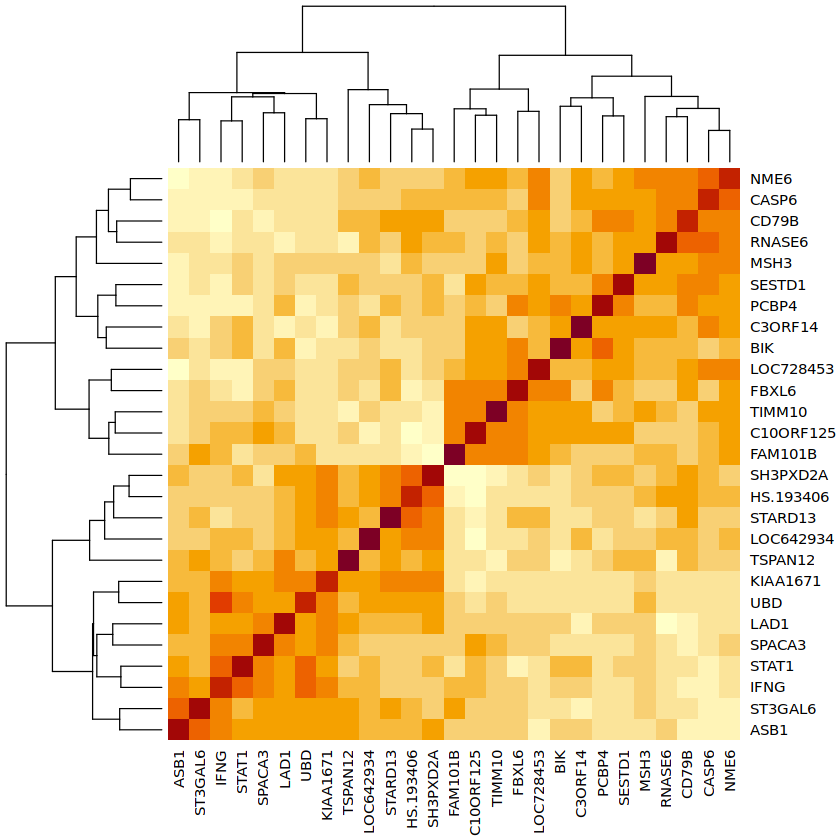

In [16]:
# Code cell n°16

heatmap(cor(t(norm_sig)))

- with the `corrplot()` function: https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html   
that allows for many improvements of the rendering

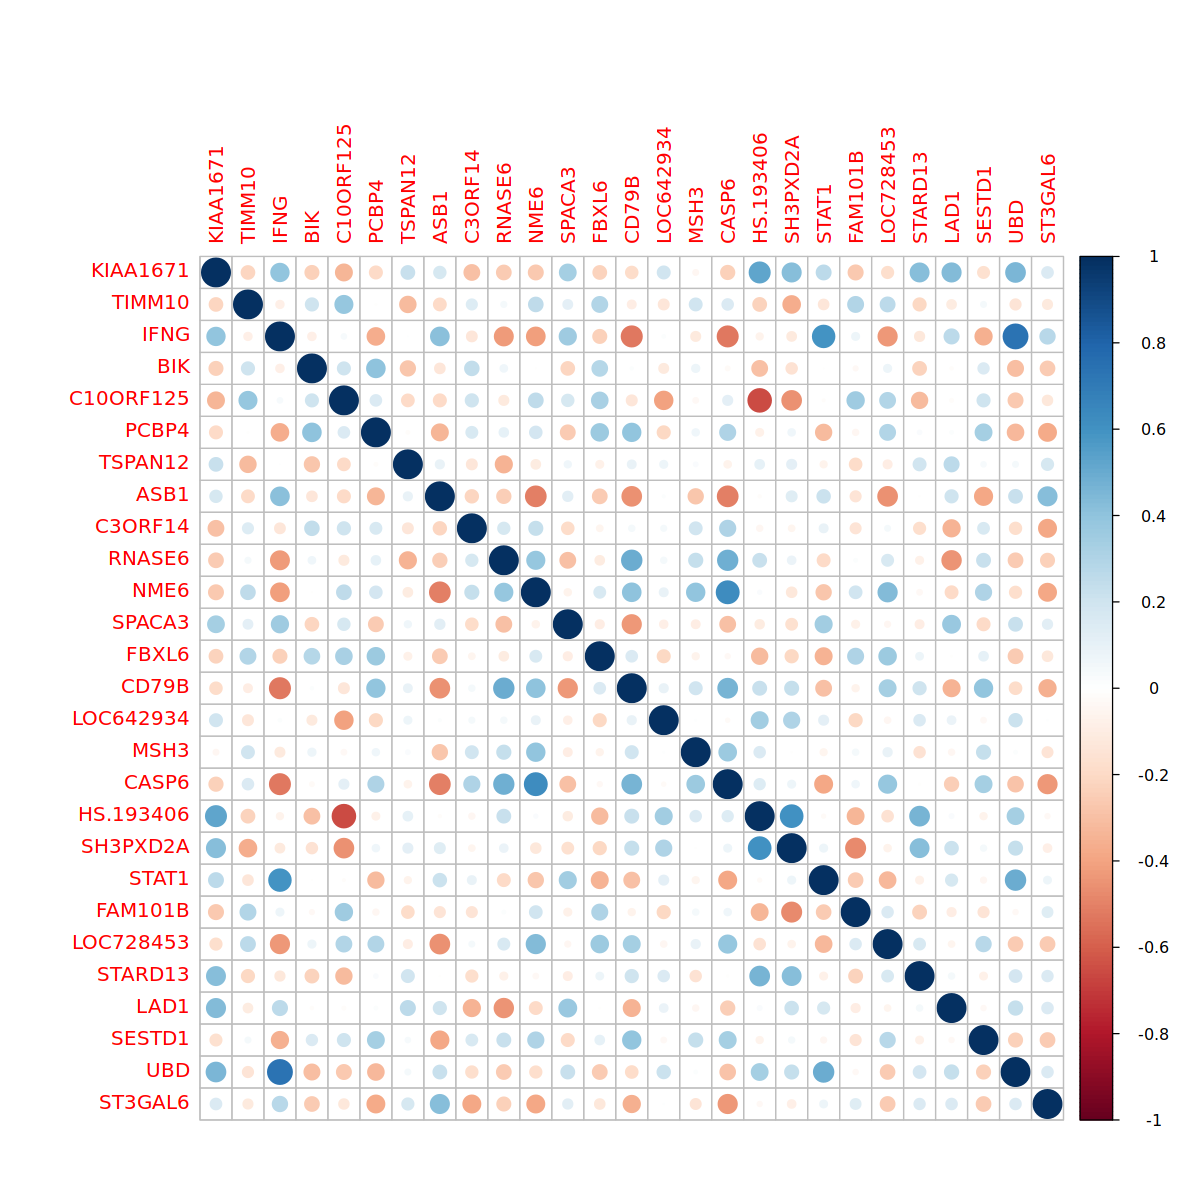

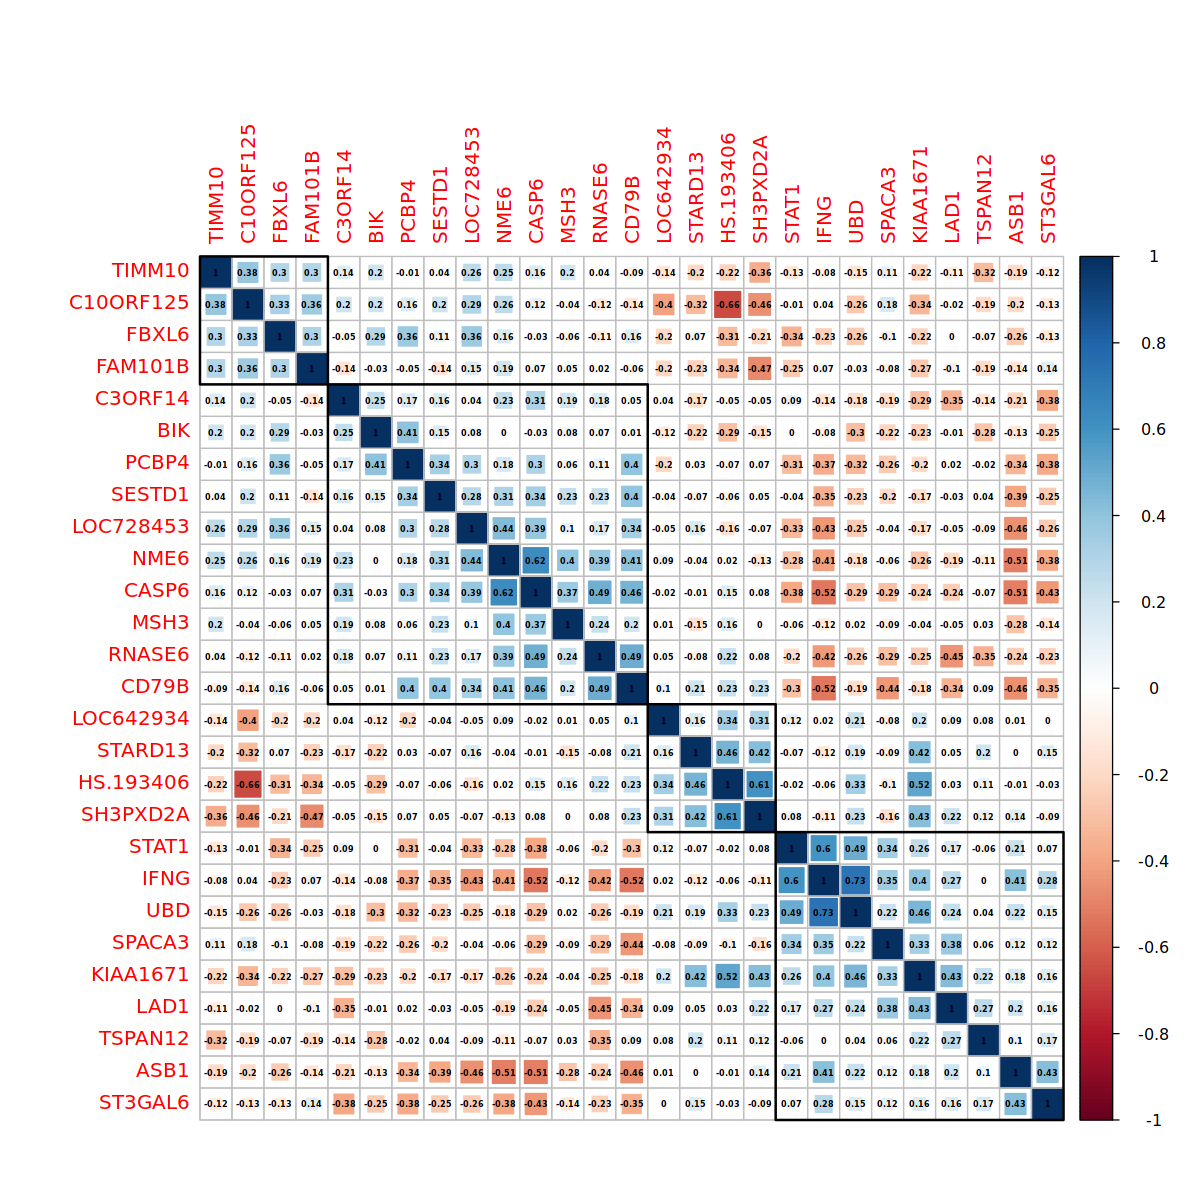

In [17]:
# Code cell n°17

options(repr.plot.width = 10, repr.plot.height = 10)
corrplot(cor(t(norm_sig)))

# method = "square" is the default 
# hclust clusterises the genes, grouping together the most correlated ones
# rectangles and correlation coefficients are also added
corrplot(cor(t(norm_sig)),
         method = "square",
         order = 'hclust',
         addrect = 4,
         addCoef.col = 'black',
         number.cex = 0.4)

<span style="color:blue"> => Find the arguments of the corrplot function in cell 18 with the only the upper matrix displayed and using an ellipse representative of each pair-wise correlation.</span>

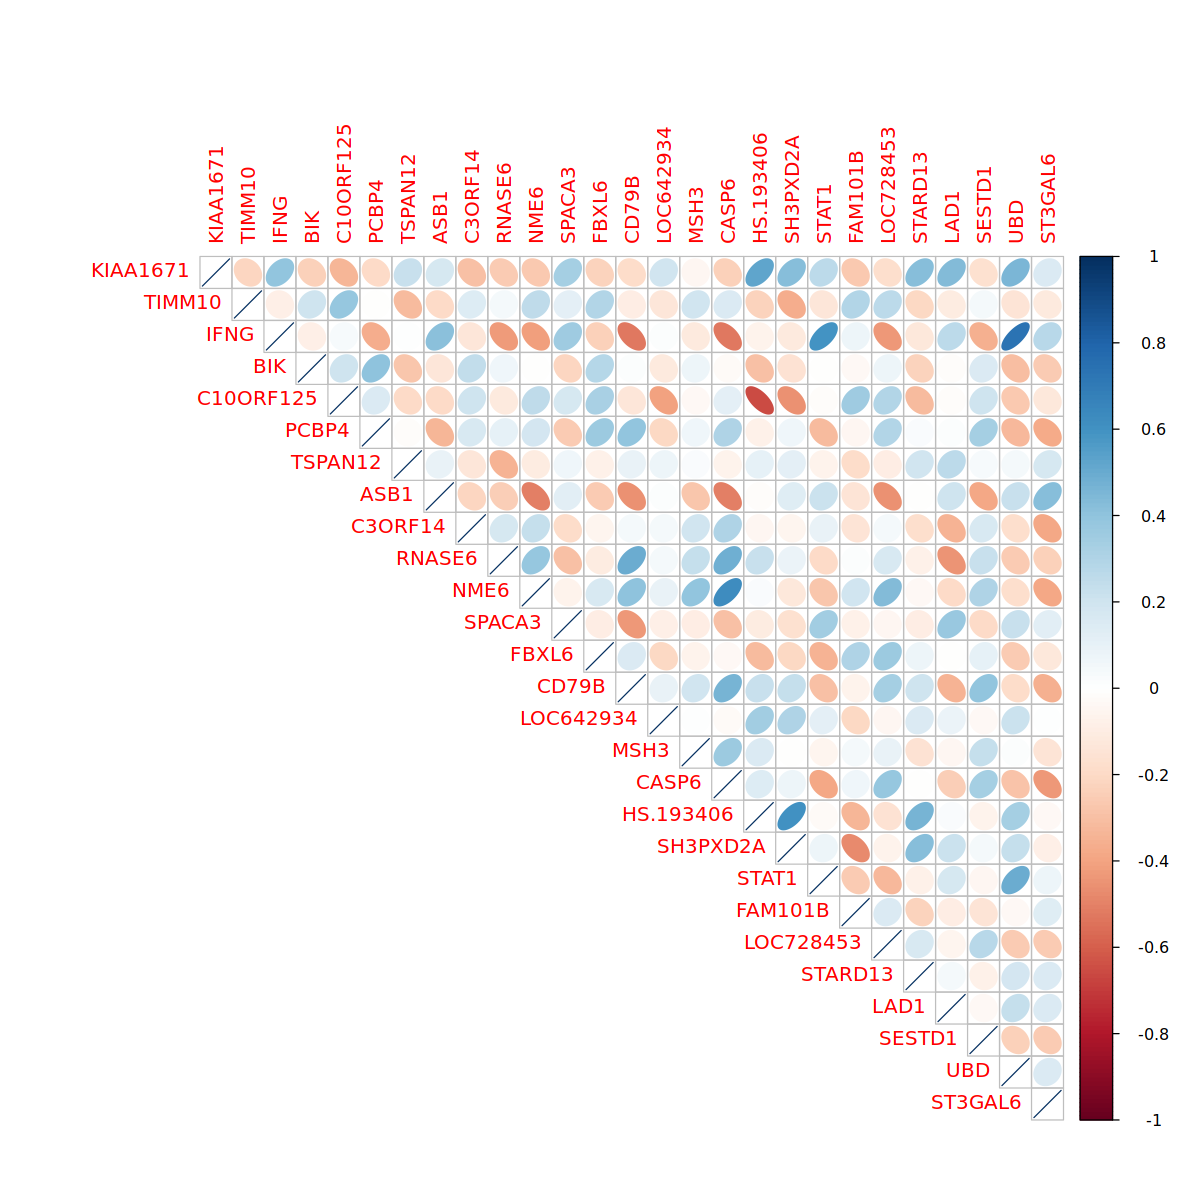

In [18]:
# Code cell n°18

# by definition a correlation matrix is symmetrical. 
# type = 'upper' will show only the upper half of the matrix
corrplot(cor(t(norm_sig)),
        method = 'ellipse',
        type = 'upper',
        insig = 'blank')

---
___

Now we go on with the analysis of enrichments of gene list of interest.  
  
**=> Step 11: Overrepresentation and enrichment analysis ** 

The jupyter notebook used for the next session will be *Pipe_11-R403-Normcounts-exploratory-analysis-II.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [ ]:
## Code cell 45 ##   

myfolder

file.copy("/shared/projects/2312_rnaseq_cea/pipeline/Pipe_11-R403-ORA-GSEA.ipynb", myfolder)




**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks' folder. Adjust the name with yours and reformat as code cell to run it.

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a normalisation and a differential expression analysis using DESeq2.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Bénédicte Noblet - 05-07 2021   
Sandrine Caburet et Claire Vandiedonck - 02-06 2023   
with adaptations from https://bioinformatics-core-shared-training.github.io/RNAseq_November_2020_remote/html/02_Preprocessing_Data.html   
and https://rpubs.com/adoughan/778146  
Maj 01/06/2023 par @SCaburet   